# Maria's notebook

Analysis of miscarriage and depression using Twitter data from relevant dates to the topic. I will explore:
1. Most prolific authors
2. Tweets/day
3. Correlation
4. Sentiment analysis related to popularity

### Import the neccesary libraries and modules to the notebook

In [1]:
#Data operations (visualize and manipulate)

import json
import missingno as msno
import csv
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import Series

In [2]:
#Packages for text cleaning 

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
#Time and dates management

from datetime import datetime
import time

In [4]:
#Sentiment analysis

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
#nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

In [5]:
#Topic extraction

import gensim
from gensim import corpora, models
from gensim.matutils import jaccard
from gensim.models import LdaModel
from gensim.models import CoherenceModel

In [6]:
#Data visualization

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

The data that will be used is stored in the DataCollection folder. 


In [7]:
path_tweets = 'dataCollection/tweets_miscarriage_all_wo_reply.json'
print(path_tweets)

dataCollection/tweets_miscarriage_all_wo_reply.json


In [8]:
#A list is created with all the collected tweets & metadata (author, date, time, metrics, etc).

tweets = list()
n = 0
#To make sure all tweets are read
max_row = 10000000  

#Open(.., 'r') only read mode. t=tweets & l=loads
with open(path_tweets, 'r') as t: 
    for l in t: 
        tweets.append(json.loads(l))    #Creates a diccionary

#Creation of a dataframe with all the compiled information
df = pd.DataFrame(tweets)

In [9]:
#Visualize the dataframe and its columns
print(f'This is the original columns without any transformation: {df.columns}\n')

#Take a sample from the population
#df = df.sample(n = 10000, axis=0)
len_initial = len(df)

print(f"The dataframe has {len(df)} entries\n")
print(f"The dataframe has {len(df.axes[1])} columns or observations\n")


This is the original columns without any transformation: Index(['_id', 'id', 'author', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'public_metrics', 'text',
       'referenced_tweets', 'attachments', 'geo', 'withheld'],
      dtype='object')

The dataframe has 97965 entries

The dataframe has 14 columns or observations



In [10]:
#Createa a function to normalize the json data and transform into a dictionary format 
def normalized_data(df, col):
    df2 = pd.json_normalize(df[col])
    df2.columns = ['{}.{}'.format(col, x) for x in df2.columns]
    df = df.join(df2)
    del df[col]
    return df

In [11]:
#Apply transformations on the fields of our interest
df = normalized_data(df, 'author')
df = normalized_data(df, 'public_metrics')
df = normalized_data(df, 'geo')

In [12]:
#Print again to watch the transformation on the columns
print(f"These are the new columns: {df.columns}\n")

These are the new columns: Index(['_id', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', 'referenced_tweets',
       'attachments', 'withheld', 'author.id', 'author.username',
       'author.created_at', 'author.name', 'author.location',
       'author.withheld.country_codes', 'author.withheld.scope',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates'],
      dtype='object')



## Languaje filtering
After columns normalization and transformation we filter the tweets in english for the sentiment analysis. We also perform additional operations, but in this stance we wont obtain wether tweets are replies because the replies have not been obtained.

This function won't be necessary since the data collection did not include the replies:


def is_reply(df):
   
           df['is_reply'] = df['in_reply_to_user_id'].apply(lambda x: False if np.isnan(float(x)) else True)
            return df

In [13]:
#Filtering the tweets that are only in english
def filter_English_tweets(df):
    df = df[df['lang'] == 'en']
    return df

In [14]:
#New function that applies the previous ones to the df
def apply_transformations(df):

    df = filter_English_tweets(df) 
   # df = media_extraction(df)
    return df

In [15]:
#Apply the function for transformations
df = apply_transformations(df)
len_after = len(df)

In [16]:
print(f"Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have {len(df)} entries in the dataframe")

Before filtering the tweets we had 97965 entries, while now that we excluded those not in english we have 92296 entries in the dataframe


{'initial': 97965, 'after': 92296}


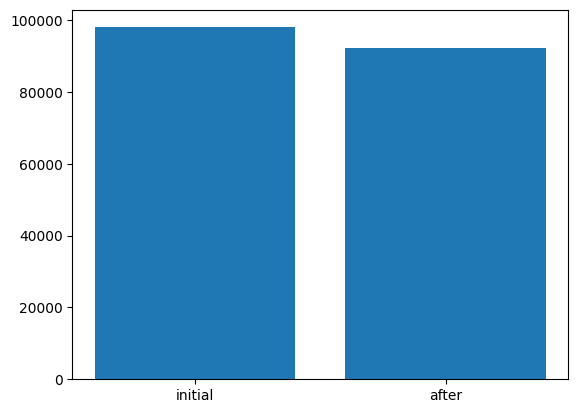

In [17]:
len_data = {'initial':len_initial, 'after':len_after}
print(len_data)

plt.bar(*zip(*len_data.items()))
plt.show()

<AxesSubplot: >

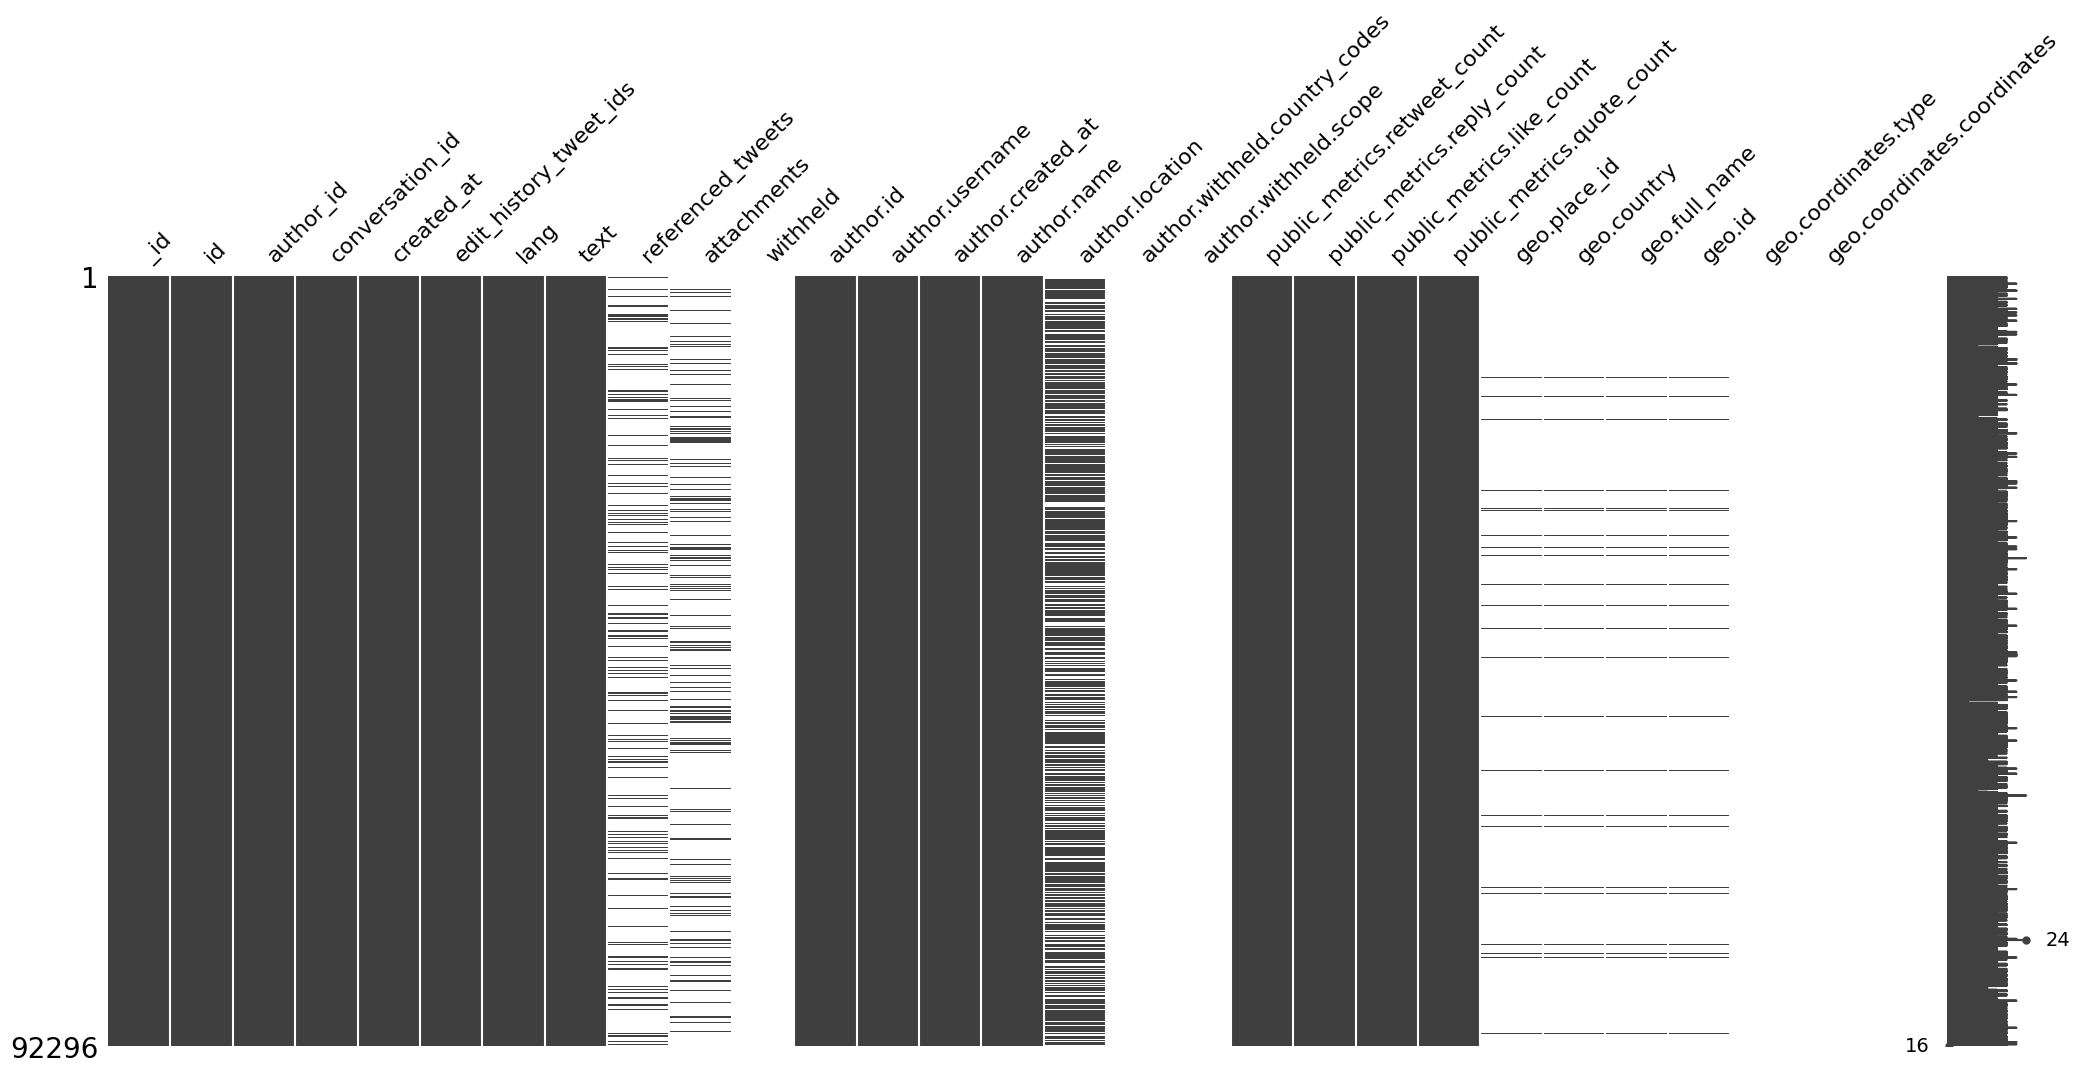

In [18]:
#This allows us to see the lenght (bottom left corner) as well as the density of information in each column 
msno.matrix(df)

### Text cleaning for the sentiment analysis

In [19]:
# Functions the mentioned text cleaning steps


# Removing extra spaces from all texts
def remove_extra_spaces(sentence):
    sentence = sentence.replace(r'\n',' ', regex=True) 
    sentence = sentence.replace(r'/\|/g',' ', regex=True) 
    return sentence


def lowercase_text(sentence):
    return sentence.lower()

def remove_usernames(sentence):
    sentence = re.sub(r'@\w+',' ', sentence)
    return sentence

def remove_hashtags(sentence):
    sentence = re.sub(r"#\w+",' ', sentence)
    return sentence

def remove_links(sentence):
    sentence = re.sub(r'\bhttps?://[^\s]*',' ', sentence)
    return sentence

def remove_numbers(sentence):
    sentence = re.sub(r'\d+',' ', sentence)
    return sentence

def remove_punctuation_and_spaces(sentence):
    sentence = re.sub(r'&', ' ', sentence) # Specific for &
    sentence = re.sub(r'[^\w\s]',' ', sentence)
    sentence = ' '.join(sentence.split())
    return sentence

def remove_1letter_words(sentence):
    sentence = re.sub(r'\b\w{1}\b', ' ', sentence)
    return sentence

def tokenize(sentence):
    list_of_words = sentence.split(" ")
    return list_of_words

def remove_stopwords(list_of_words):
    # Getting English stopwords
    stop_words = set(stopwords.words('english'))

    filtered_words = []
    for word in list_of_words: 
        if word not in stop_words: 
            filtered_words.append(word) 

    return filtered_words

def lemmatize(list_of_words):
    # Getting English lemmatizer
    wordnet_lemmatizer = WordNetLemmatizer()
    
    lemma_words = []
    for w in list_of_words:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n") # Names
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v") # Verbs
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = "a") # Adjectives
        lemma_words.append(word3)

    return lemma_words


     

# Function to apply all text tranformations
def text_cleaning(df):
    '''
    Given a pandas dataframe with tweets returns a list of clean tweet texts
    @input: pandas dataframe with tweets
    @output: list of clean tweets (same order as in df)
    '''
    lists_of_text = []

    for text in df['text']:
        sentence = str(text)

        # Text transformations
        sentence = lowercase_text(sentence) # All in lowercase
       # sentence = remove_extra_spaces(sentence)

        sentence = remove_links(sentence) # Remove links
        sentence = remove_hashtags(sentence) # Remove Hashtags
        sentence = remove_usernames(sentence) # Remove usernames
        sentence = remove_numbers(sentence) # Remove numbers
        sentence = remove_punctuation_and_spaces(sentence) # Remove punctuation signs and multiple spaces
        sentence = remove_1letter_words(sentence) # Remove words with len=1
        sentence = remove_punctuation_and_spaces(sentence)
        
        list_of_words = tokenize(sentence) # Tokenization
        list_of_words = remove_stopwords(list_of_words) # Remove stopwords
        list_of_words = lemmatize(list_of_words) # Lemmatization
        
        # Converting list of words to text again
        lists_of_text.append(' '.join(list_of_words))

    return lists_of_text

In [20]:
df['clean_text'] = text_cleaning(df)

# Authors
We want to see the authors that have contributed the most to the total amount of tweets during the selected days.

In [21]:
#We wish to obtain the authors with most contributions, we group them by name and order (ascending)

most_prolific = df.groupby('author.username').size().sort_values(ascending = False)
most_prolific

author.username
TomthunkitsMind    462
LifeNewsHQ         134
littlebytesnews    127
LifeNewsToo        127
Inspiredtvgh       119
                  ... 
NewsUSAofficial      1
NewsViews_           1
NewsVirginian        1
NewsWire_US          1
zzzi_ki              1
Length: 54013, dtype: int64

In [22]:
#We transform it into a data frame and reset the index to transform the name of the author (which is used as an index atm)

#To transform index into column we use .reset_index()

df_most_prolific = pd.DataFrame(most_prolific).reset_index()

In [23]:
df_most_prolific.columns = ["author_id", "count"]

In [24]:
df_most_prolific_15_most = df_most_prolific.head(15)
df_most_prolific_15_most

,author_id,count
0,TomthunkitsMind,462
1,LifeNewsHQ,134
2,littlebytesnews,127
3,LifeNewsToo,127
4,Inspiredtvgh,119
5,zhouzhoujyk,109
6,SafetyPinDaily,109
7,youkayoyo10059,107
8,g_kraig,102
9,br00t4c,97


Text(0, 0.5, 'Author username')

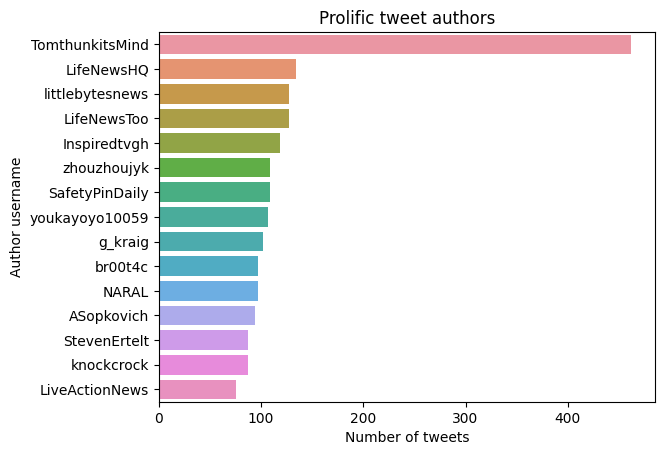

In [25]:
sns.barplot(
    x = df_most_prolific_15_most['count'],
     y = df_most_prolific_15_most['author_id'])
plt.title("Prolific tweet authors")
plt.xlabel("Number of tweets")
plt.ylabel("Author username")

## Dates
Explore as well the dates where the tweets were made, to compare between them. 
First we need to make sure our created_at column is a datetime object

In [26]:
# Transform into date time object ( datetime 64= yyyy-mm-dd-, 
#"ns" = nanosecond)
df['created_at'] = df['created_at'].astype('datetime64[ns]') 

In [27]:
df.loc[:,"created_at"] 

0       2021-10-14 23:58:58
1       2021-10-14 23:58:52
3       2021-10-14 23:58:47
4       2021-10-14 23:58:43
5       2021-10-14 23:58:21
                ...        
97959   2022-09-28 23:59:48
97961   2022-09-28 23:59:09
97962   2022-09-28 23:59:06
97963   2022-09-28 23:59:05
97964   2022-09-28 23:59:00
Name: created_at, Length: 92296, dtype: datetime64[ns]

In [28]:
#df['created_at'] = pd.to_datetime(df['created_at']).dt.normalize()
df['time'] = pd.to_datetime(df['created_at']).dt.time

df['date'] = df['created_at'].dt.date
df['date'] = df['date'].astype('datetime64[ns]')

df.columns

Index(['_id', 'id', 'author_id', 'conversation_id', 'created_at',
       'edit_history_tweet_ids', 'lang', 'text', 'referenced_tweets',
       'attachments', 'withheld', 'author.id', 'author.username',
       'author.created_at', 'author.name', 'author.location',
       'author.withheld.country_codes', 'author.withheld.scope',
       'public_metrics.retweet_count', 'public_metrics.reply_count',
       'public_metrics.like_count', 'public_metrics.quote_count',
       'geo.place_id', 'geo.country', 'geo.full_name', 'geo.id',
       'geo.coordinates.type', 'geo.coordinates.coordinates', 'clean_text',
       'time', 'date'],
      dtype='object')

In [29]:
#Delete the dates that are not wanted
df = df[df['date'] != '2021-09-26']
df = df[df['date'] != '2021-10-13']
df = df[df['date'] != '2022-09-26']
df = df[df['date'] != '2022-10-13']

#### Create a column named event
We need to compare between the two different events from two years

In [30]:
def categorize_all_events(df):
    df['event'] = ''
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2021-09-29').date()), 'event'] = 'Abortion 21'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-09-27').date()) & (df['date'].dt.date <= pd.to_datetime('2022-09-29').date()), 'event'] = 'Abortion 22'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2021-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2021-10-16').date()), 'event'] = 'Miscarriage 21'
    df.loc[(df['date'].dt.date >= pd.to_datetime('2022-10-14').date()) & (df['date'].dt.date <= pd.to_datetime('2022-10-16').date()), 'event'] = 'Miscarriage 22'
    return df

df = categorize_all_events(df)


In [31]:
#we group by date and create a new dataframe for data manipulation
df_dates = df.groupby(pd.Grouper(key='date'))['date'].count()

#Transform the dataset into a dataframe for manipulation
df_dates = pd.DataFrame(df_dates)

#Reset the index to rename the columns and plot the results
df_dates.columns = ['count']
df_dates = df_dates.reset_index()
df_dates.columns = ['date', 'count']

#Retransform into time object
df_dates['date'] = df_dates['date'].astype('datetime64[ns]')
df_dates = df_dates.sort_values(by = 'date')

df_dates

,date,count
3,2021-09-27,5740
4,2021-09-28,6824
5,2021-09-29,6406
0,2021-10-14,4993
1,2021-10-15,6977
2,2021-10-16,3098
9,2022-09-27,12753
10,2022-09-28,11471
11,2022-09-29,11443
6,2022-10-14,8511


In [32]:
#Filter out the tweets made at midnight of the desired days (not necessary not because of a step above)
df_dates = df_dates[df_dates['count'] >= 10]

#Visualize again the df
df_dates

,date,count
3,2021-09-27,5740
4,2021-09-28,6824
5,2021-09-29,6406
0,2021-10-14,4993
1,2021-10-15,6977
2,2021-10-16,3098
9,2022-09-27,12753
10,2022-09-28,11471
11,2022-09-29,11443
6,2022-10-14,8511


#### Analysis of tweets per day

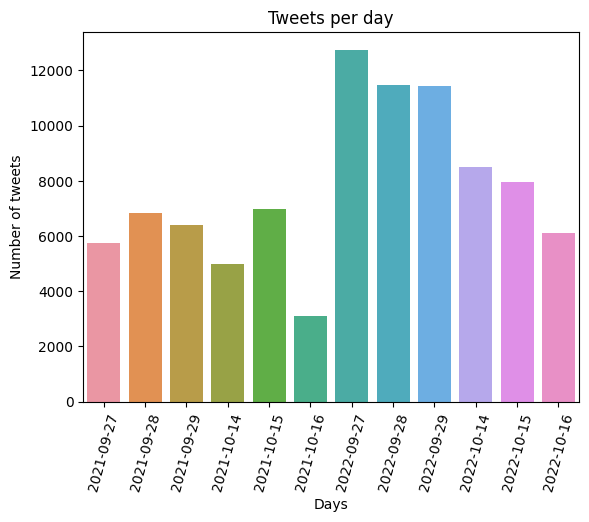

In [33]:
tweets_day = sns.barplot(
    x = df_dates['date'].dt.date.astype(str),
     y = df_dates['count'])
plt.title("Tweets per day")
plt.xlabel("Days")
plt.ylabel("Number of tweets")
plt.xticks(rotation=75)
plt.show()

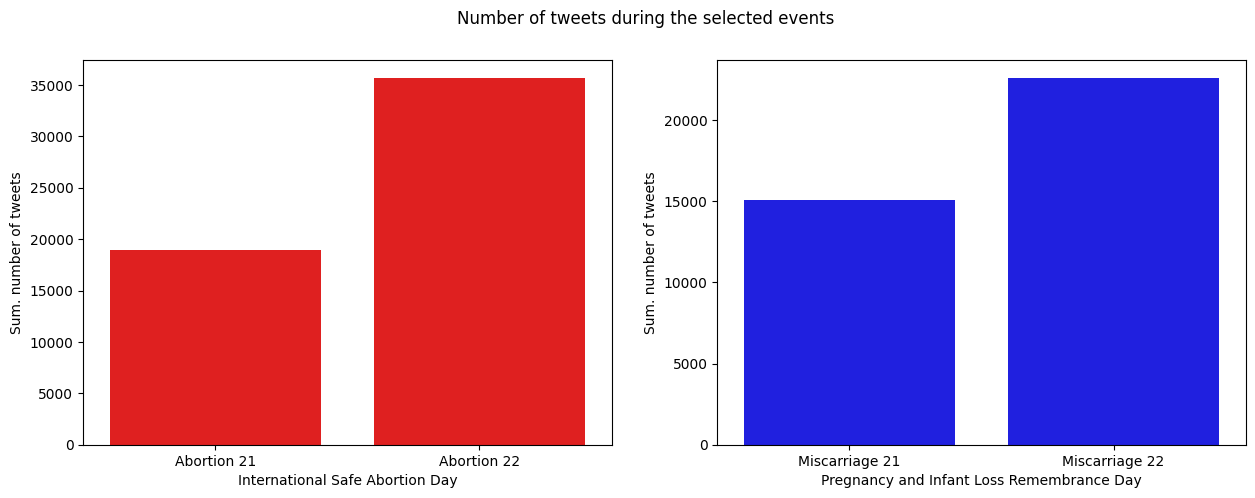

In [34]:
#Categorize by events to compare in graph
df_dates = categorize_all_events(df_dates)

#create subplots to show the two different events
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# create first bar plot for the International Safe Abortion Day 
#With isin() we select the events that match the argument
df_abortion = df_dates[df_dates['event'].isin(['Abortion 21', 'Abortion 22'])]
#groupby the two different years and get the sum count for the plot
df_abortion = df_abortion.groupby('event').agg({'count':'sum'}).reset_index()
#Plot
sns.barplot(x='event', y='count', data=df_abortion, color='red', ax=axs[0])
fig.suptitle('Number of tweets during the selected events')
axs[0].set_xlabel('International Safe Abortion Day')
axs[0].set_ylabel('Sum. number of tweets')

# create second bar plot
df_miscarriage = df_dates[df_dates['event'].isin(['Miscarriage 21', 'Miscarriage 22'])]
df_miscarriage = df_miscarriage.groupby('event').agg({'count':'sum'}).reset_index()
sns.barplot(x='event', y='count', data=df_miscarriage, color='blue', ax=axs[1])
axs[1].set_xlabel('Pregnancy and Infant Loss Remembrance Day')
axs[1].set_ylabel('Sum. number of tweets')

plt.show()

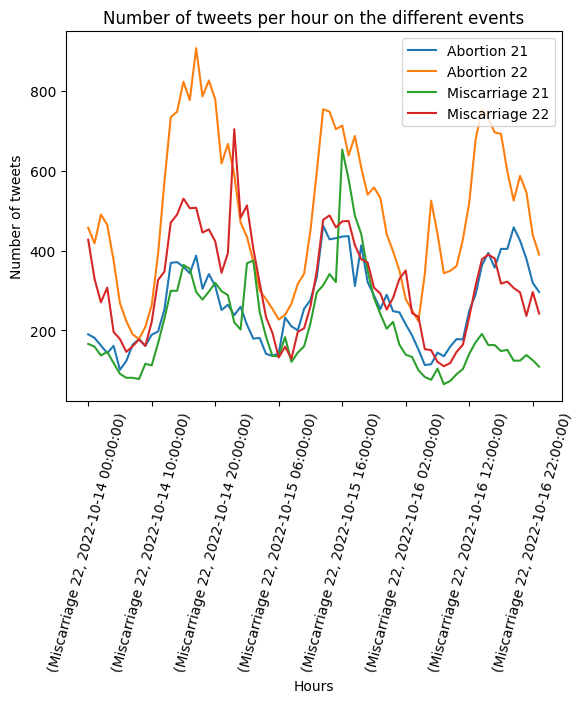

In [55]:
# Group the data by event and hour
grouped = df.groupby(['event', pd.Grouper(key='created_at', freq='H')])

# resample the data by hour
resampled = grouped['event'].count()

# plot the tweets per hour for each event
for event, data in resampled.groupby(level=0):
    data.plot(label=event)
plt.title('Number of tweets per hour on the different events')   
plt.xlabel("Hours")
plt.ylabel("Number of tweets")
plt.legend()
plt.xticks(rotation=75)
plt.show()

# Sentiment Analysis
### Interactions and emotions

To study wether the tweets with more interactions have a positive or negativ emotion we have to:
1. Group by cols
2. Choose a sample population with the most liked tweets
3. Perform sentiment analysis


In [36]:
#Analyze all tweets to get the most positive and the most negative ones
#Choose only the relevant columns for the study

df_allsentiment = df[['created_at', 'author.username', 'public_metrics.retweet_count', 'public_metrics.reply_count', 'public_metrics.like_count', 'clean_text', 'event']]
df_allsentiment.rename(columns = {'clean_text':'text'}, inplace = True)

def sentiment_analysis_polarity_NLTK(df):
    '''
    Given a dataframe with tweets, it add 4 new columns to express sentiment polarity:
    negative score, positive score, neutral score and compound
    '''

    sia = SentimentIntensityAnalyzer()

    tweets = df_allsentiment['text']

    negative_values = []
    neutral_values = []
    positive_values = []
    compound_values = []

    for tweet in tweets:
        polarity_dict = sia.polarity_scores(tweet)
        
        negative_values.append(polarity_dict['neg'])
        neutral_values.append(polarity_dict['neu'])
        positive_values.append(polarity_dict['pos'])
        compound_values.append(polarity_dict['compound'])

    df['polarity_negative'] = negative_values
    df['polarity_positive'] = positive_values
    df['polarity_neutral'] = neutral_values
    df['polarity_compound'] = compound_values
    
    return df


df_allsentiment_transformed = sentiment_analysis_polarity_NLTK(df_allsentiment)

/tmp/ipykernel_150624/3119442842.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment.rename(columns = {'clean_text':'text'}, inplace = True)
/tmp/ipykernel_150624/3119442842.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['polarity_negative'] = negative_values
/tmp/ipykernel_150624/3119442842.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

In [37]:
#Function to obtain subjectivity
def subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#Function for general polarity
def polarity(text):
    return TextBlob(text).sentiment.polarity

df_allsentiment_transformed['subjectivity'] = df_allsentiment_transformed['text'].apply(subjectivity)
df_allsentiment_transformed['polarity'] = df_allsentiment_transformed['text'].apply(polarity)

/tmp/ipykernel_150624/2417025554.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['subjectivity'] = df_allsentiment_transformed['text'].apply(subjectivity)
/tmp/ipykernel_150624/2417025554.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['polarity'] = df_allsentiment_transformed['text'].apply(polarity)


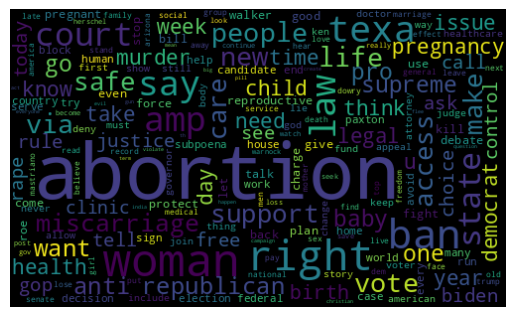

In [38]:
#Plot word cloud
#Important to add the collocations=False, otherwise we will get composite word results as 'Abortion ban', 'Abortion law', etc.
allWords = ' '.join( [text.strip() for text in df_allsentiment_transformed['text']] )
wordCloud = WordCloud(width = 500, height = 300, random_state = 21, collocations = False).generate(allWords)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [39]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

df_allsentiment_transformed['analysed'] = df_allsentiment_transformed['polarity'].apply(getAnalysis)
df_allsentiment_transformed



/tmp/ipykernel_150624/1615155637.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['analysed'] = df_allsentiment_transformed['polarity'].apply(getAnalysis)


,created_at,author.username,public_metrics.retweet_count,public_metrics.reply_count,public_metrics.like_count,text,event,polarity_negative,polarity_positive,polarity_neutral,polarity_compound,subjectivity,polarity,analysed
0,2021-10-14 23:58:58,yasplox,0,0,0,abortion remedy medieval catholic nun via,Miscarriage 21,0.000,0.000,1.000,0.0000,0.050000,0.000000,Neutral
1,2021-10-14 23:58:52,RegisterCitizen,0,0,0,lawsuit challenge state law aim anti abortion ...,Miscarriage 21,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
3,2021-10-14 23:58:47,StamAdvocate,0,0,0,lawsuit challenge state law aim anti abortion ...,Miscarriage 21,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
4,2021-10-14 23:58:43,EricTerman,0,0,0,identity politics evil abortion evil open bord...,Miscarriage 21,0.636,0.143,0.221,-0.9758,0.870635,-0.590476,Negative
5,2021-10-14 23:58:21,marcia4justice,0,0,0,furthermore imprison woman suffer miscarriage ...,Miscarriage 21,0.320,0.133,0.547,-0.7003,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97959,2022-09-28 23:59:48,GretchenJBerg,20,4,62,part coalition television showrunners creator ...,Abortion 22,0.141,0.152,0.707,0.0516,0.000000,0.000000,Neutral
97961,2022-09-28 23:59:09,Aleja_487,3,0,4,day since nj legislator stall critical abortio...,Abortion 22,0.269,0.311,0.420,0.2500,0.661111,0.066667,Positive
97962,2022-09-28 23:59:06,delanybomb,0,0,1,say say anything say woman center woman clinic...,Abortion 22,0.133,0.000,0.867,-0.3182,0.166667,0.000000,Neutral
97963,2022-09-28 23:59:05,ROJNAME_english,0,0,0,mastriano woman face murder charge violate abo...,Abortion 22,0.657,0.000,0.343,-0.9100,0.000000,0.000000,Neutral


In [40]:
from pandas.core.apply import frame_apply

In [41]:
#Change column names
df_allsentiment_transformed.columns = ['created_at', 'author', 'rt', 'replies', 'likes', 'text', 'event', 'negative', 'positive', 'neutral', 'compound', 'subjectivity', 'polarity', 'analysed']

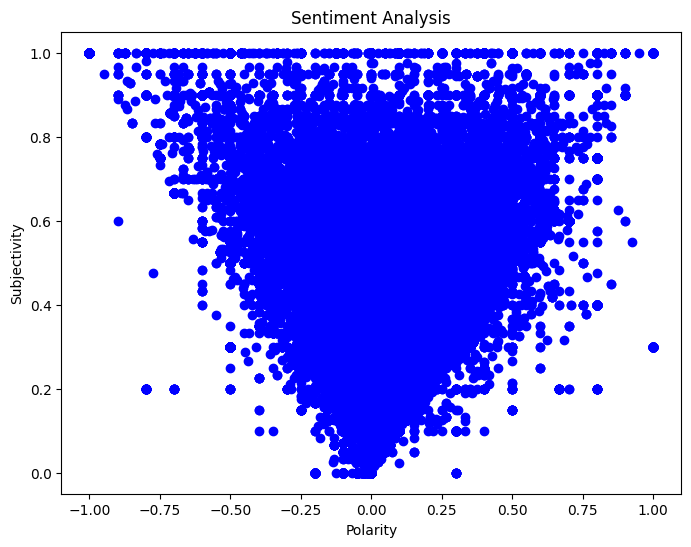

In [42]:
#Plot polarity and subjectivity
plt.figure(figsize=(8,6))
plt.scatter(df_allsentiment_transformed['polarity'], df_allsentiment_transformed['subjectivity'], color = 'Blue')
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

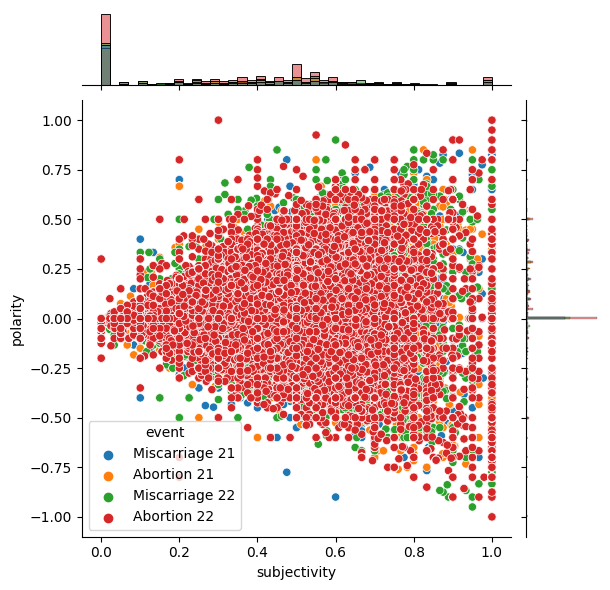

In [43]:
g = sns.JointGrid(data=df_allsentiment_transformed, x="subjectivity", y="polarity", hue="event")
g.plot(sns.scatterplot, sns.histplot)

In [44]:
#Percentages of positive tweets
positivetwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Positive']
positiveper100 = round( (positivetwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of positives is:', positiveper100)

#Percentages of positive tweets
negativetwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Negative']
negativeper100 = round( (negativetwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of negatives is:', negativeper100)

#Percentages of neutral tweets
neutraltwt = df_allsentiment_transformed[df_allsentiment_transformed['analysed'] == 'Neutral']
neutralper100 = round( (neutraltwt.shape[0]/df_allsentiment_transformed.shape[0])*100, 1)
print('The percentaje of neutrals is:', neutralper100)

The percentaje of positives is: 45.3
The percentaje of negatives is: 19.9
The percentaje of neutrals is: 34.8


<AxesSubplot: title={'center': 'Sentiment analysis'}, xlabel='Sentiment', ylabel='Counts'>

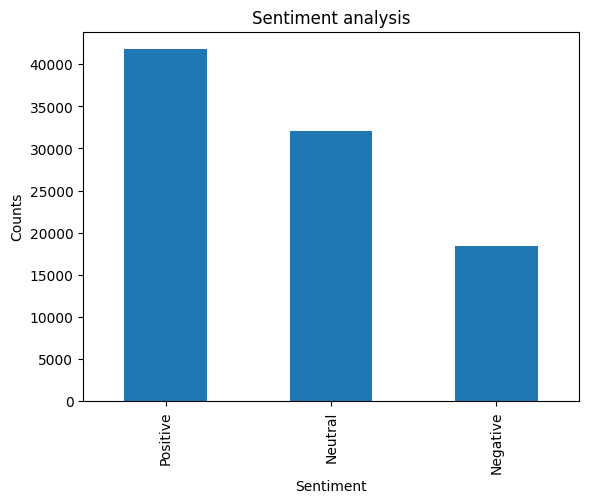

In [45]:
#Visualize the counts ( or percentages)
plt.title('Sentiment analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_allsentiment['analysed'].value_counts().plot(kind = 'bar')

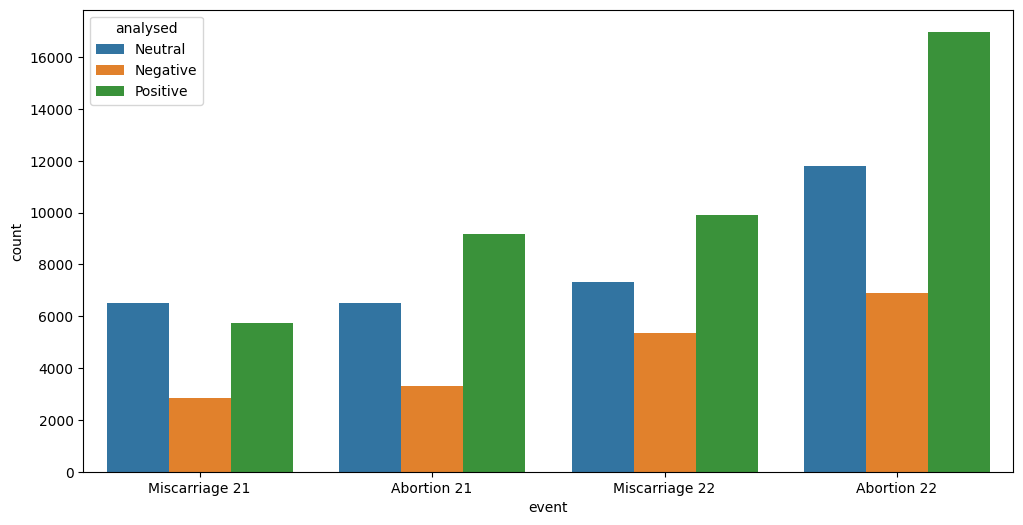

In [58]:
plt.figure(figsize=(12,6))
sns.countplot(x='event', hue='analysed', data= df_allsentiment_transformed)
plt.show()

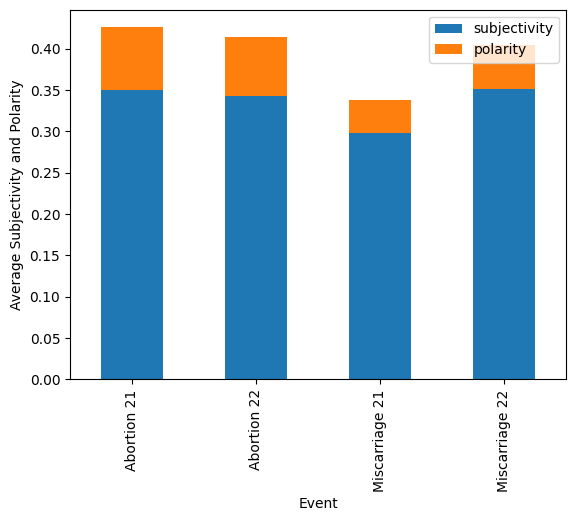

In [57]:
# Group data by event
grouped = df_allsentiment_transformed.groupby('event')

# Calculate average subjectivity and polarity for each group
averages = grouped[['subjectivity', 'polarity']].mean()

averages.plot(kind='bar', y=['subjectivity', 'polarity'], stacked=True)
plt.xlabel('Event')
plt.ylabel('Average Subjectivity and Polarity')
plt.show()

## Correlation analysis

In [48]:
#Transform columns of the dataframe to log.scale for the scatter plot and correlation analysis
df_allsentiment_transformed['rt'] = np.log1p(df_allsentiment_transformed['rt'])
df_allsentiment_transformed['likes'] = np.log1p(df_allsentiment_transformed['likes'])
df_allsentiment_transformed['replies'] = np.log1p(df_allsentiment_transformed['replies'])

df_allsentiment_transformed

/tmp/ipykernel_150624/680800234.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['rt'] = np.log1p(df_allsentiment_transformed['rt'])
/tmp/ipykernel_150624/680800234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_allsentiment_transformed['likes'] = np.log1p(df_allsentiment_transformed['likes'])
/tmp/ipykernel_150624/680800234.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,created_at,author,rt,replies,likes,text,event,negative,positive,neutral,compound,subjectivity,polarity,analysed
0,2021-10-14 23:58:58,yasplox,0.000000,0.000000,0.000000,abortion remedy medieval catholic nun via,Miscarriage 21,0.000,0.000,1.000,0.0000,0.050000,0.000000,Neutral
1,2021-10-14 23:58:52,RegisterCitizen,0.000000,0.000000,0.000000,lawsuit challenge state law aim anti abortion ...,Miscarriage 21,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
3,2021-10-14 23:58:47,StamAdvocate,0.000000,0.000000,0.000000,lawsuit challenge state law aim anti abortion ...,Miscarriage 21,0.365,0.113,0.522,-0.4404,0.100000,-0.100000,Negative
4,2021-10-14 23:58:43,EricTerman,0.000000,0.000000,0.000000,identity politics evil abortion evil open bord...,Miscarriage 21,0.636,0.143,0.221,-0.9758,0.870635,-0.590476,Negative
5,2021-10-14 23:58:21,marcia4justice,0.000000,0.000000,0.000000,furthermore imprison woman suffer miscarriage ...,Miscarriage 21,0.320,0.133,0.547,-0.7003,0.000000,0.000000,Neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97959,2022-09-28 23:59:48,GretchenJBerg,3.044522,1.609438,4.143135,part coalition television showrunners creator ...,Abortion 22,0.141,0.152,0.707,0.0516,0.000000,0.000000,Neutral
97961,2022-09-28 23:59:09,Aleja_487,1.386294,0.000000,1.609438,day since nj legislator stall critical abortio...,Abortion 22,0.269,0.311,0.420,0.2500,0.661111,0.066667,Positive
97962,2022-09-28 23:59:06,delanybomb,0.000000,0.000000,0.693147,say say anything say woman center woman clinic...,Abortion 22,0.133,0.000,0.867,-0.3182,0.166667,0.000000,Neutral
97963,2022-09-28 23:59:05,ROJNAME_english,0.000000,0.000000,0.000000,mastriano woman face murder charge violate abo...,Abortion 22,0.657,0.000,0.343,-0.9100,0.000000,0.000000,Neutral


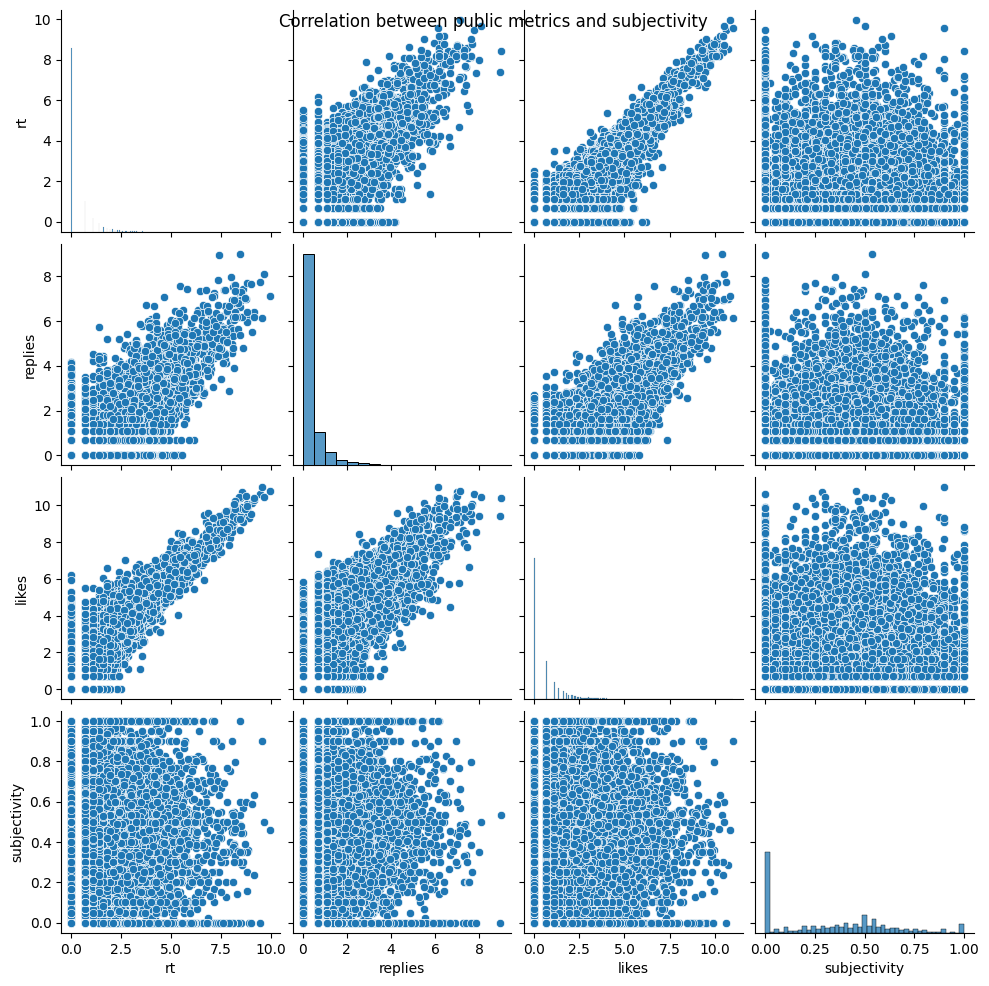

In [49]:
# Correlation between public metrics and subjectivity
g = sns.pairplot(df_allsentiment_transformed, vars=('rt', 'replies', 'likes', 'subjectivity'))
g.fig.suptitle("Correlation between public metrics and subjectivity")
plt.show()

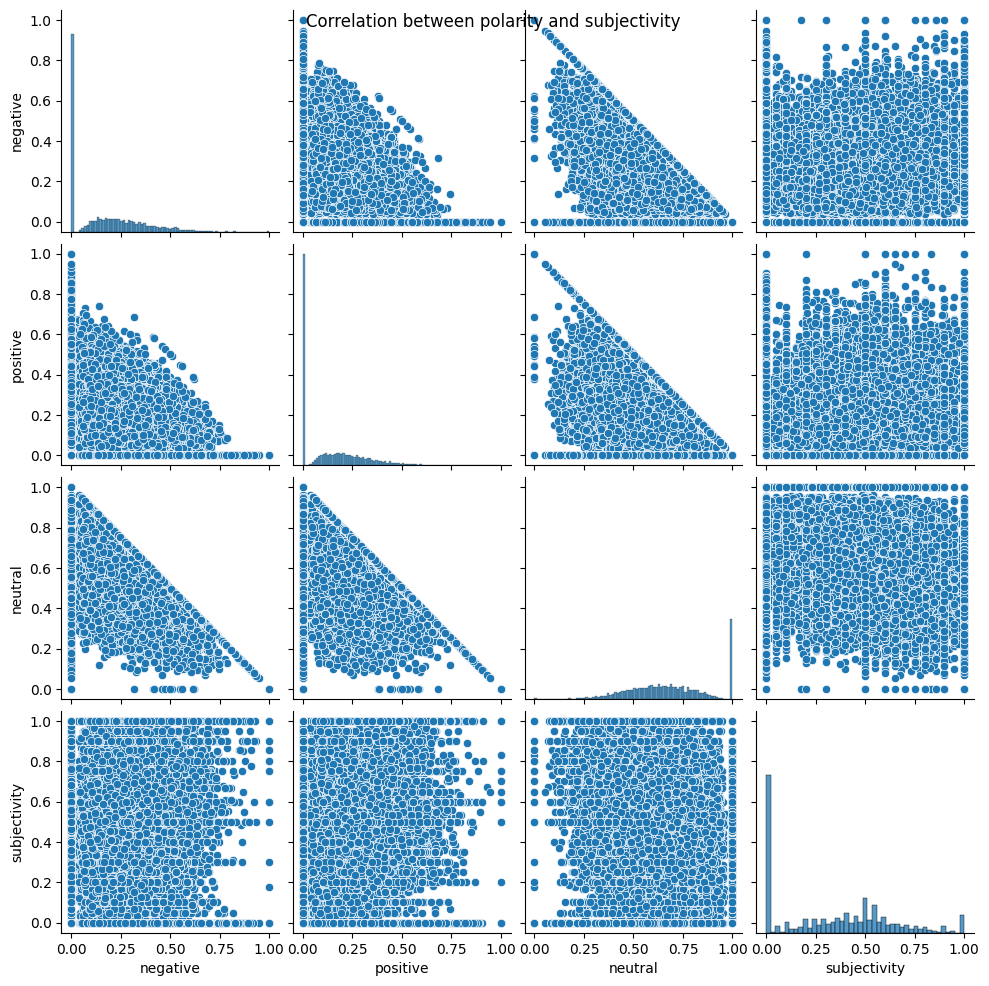

In [50]:
# Correlation between polarity and subjectivity
s = sns.pairplot(df_allsentiment_transformed, vars=('negative', 'positive', 'neutral', 'subjectivity'))
s.fig.suptitle("Correlation between polarity and subjectivity")
plt.show()

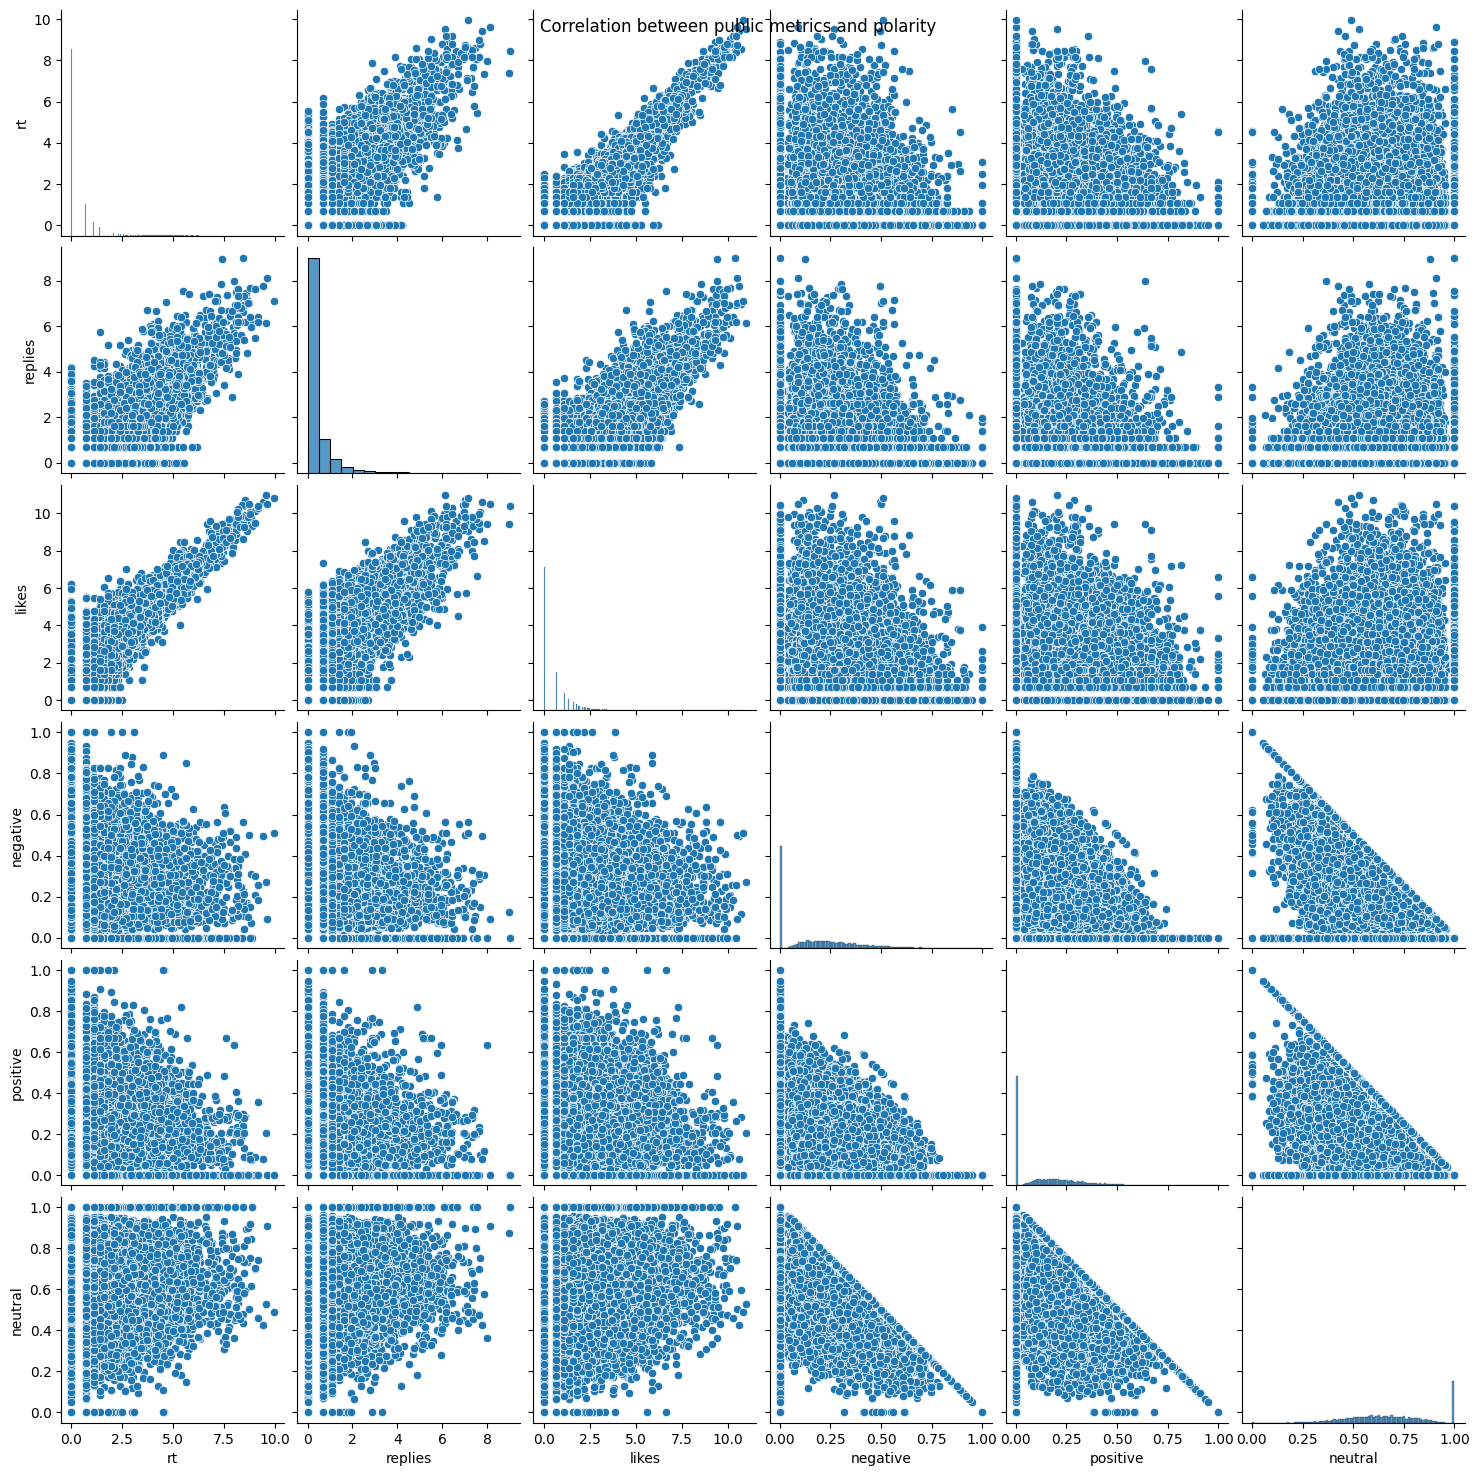

In [51]:
# Correlation between public metrics and polarity
a = sns.pairplot(df_allsentiment_transformed, vars=('rt', 'replies', 'likes', 'negative', 'positive', 'neutral'))
a.fig.suptitle("Correlation between public metrics and polarity")
plt.show()

/tmp/ipykernel_150624/963236357.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_allsentiment_transformed.corr()


<AxesSubplot: >

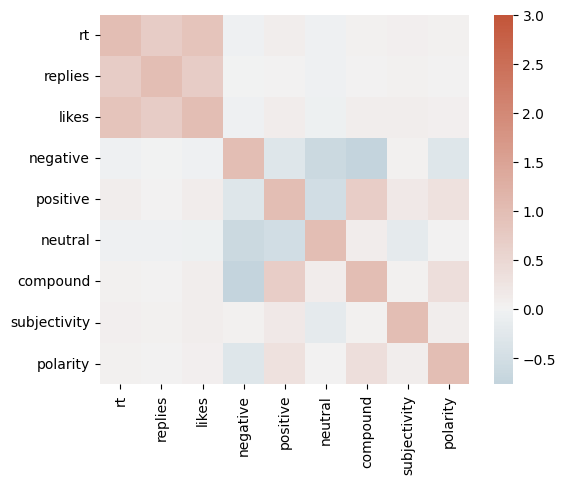

In [52]:
#Compute the correlation matrix
corr = df_allsentiment_transformed.corr()

#Generate mask for the upper triangle (so values won't repeat)
mask= np.triu(np.ones_like(corr, dtype=bool))

#Custom diverging colormap
cmap= sns.diverging_palette(230, 20, as_cmap=True)

#Heatmap 
sns.heatmap(corr, cmap=cmap, vmax=3, center=0, square=True)

/tmp/ipykernel_150624/1768119182.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_grouped = df_allsentiment_transformed.groupby([df_allsentiment_transformed['created_at'].dt.hour, 'event'])['subjectivity', 'polarity'].mean().unstack()


Text(0.5, 1.0, 'Average Subjectivity and Polarity per Hour by Event')

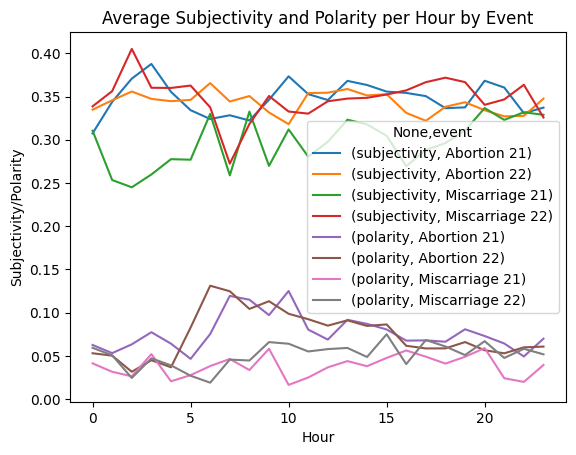

In [53]:
df_grouped = df_allsentiment_transformed.groupby([df_allsentiment_transformed['created_at'].dt.hour, 'event'])['subjectivity', 'polarity'].mean().unstack()
df_grouped.plot()
plt.xlabel('Hour')
plt.ylabel('Subjectivity/Polarity')
plt.title('Average Subjectivity and Polarity per Hour by Event')
